In [1]:
# Data preparation
import pandas as pd
import numpy as np

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [2]:
# Global variables
block_size = 16
feature_extractor = "ArcFace"

# ----
import os
save_path_plot = f"./final_eval_{feature_extractor}_biometric_system_plt/"
filename_plot = f"arcface_pemiu{block_size}_performance.svg"
os.makedirs(save_path_plot, exist_ok=True)

# Evaluation of biometric performance for PEMIU enhanced templates

Ingest dataframes containing path to LFW View 2 Target A and Target B for
- Original image
- PEMIU Shuffled embedding
- PEMIU Reconstructed embedding
- Block Size: See global variable above
- cos_sim between PEMIU Shuffled and Reconstructed embeddings

Add columns pointing to the unmodified embeddings. Reorder the columns for better readability.

In [3]:
df_genuine = pd.read_csv(f"../dataframes/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_impostor = pd.read_csv(f"../dataframes/lfw_view2_impostor_pemiu{block_size}.csv", sep=",")

# Add a column just containing the target name without extension
df_genuine['a_filename'] = df_genuine['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_genuine['b_filename'] = df_genuine['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['a_filename'] = df_impostor['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['b_filename'] = df_impostor['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Add columns with path pointing to unmodified templates
path_unmodified = "../data/features_cleaner/"
df_genuine['a_embedding_unmodified'] = df_genuine['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_genuine['b_embedding_unmodified'] = df_genuine['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['a_embedding_unmodified'] = df_impostor['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['b_embedding_unmodified'] = df_impostor['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")

# Rename index column
df_genuine = df_genuine.rename(columns = {"Unnamed: 0": "index"})
df_impostor = df_impostor.rename(columns = {"Unnamed: 0": "index"})

# Reorder columns
df_genuine = df_genuine[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

# Reorder columns
df_impostor = df_impostor[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         'a_embedding_pemiu',
                         'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         'b_embedding_pemiu',
                         
                         'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

## Calculate cos_sim

Calculate cosine similarity of
- target a / b embedding

In [4]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [5]:
# Load embeddings
genuine_a = df_genuine['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
genuine_b = df_genuine['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_a = df_impostor['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_b = df_impostor['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()

# Calculate cosine similarity using scipy spacial distance
df_genuine['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(genuine_a, genuine_b)]
df_impostor['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(impostor_a, impostor_b)]

In [6]:
df_genuine

,index,a_filename,a_img,a_embedding_unmodified,a_embedding_pemiu,a_embedding_reconstructed,b_filename,b_img,b_embedding_unmodified,b_embedding_pemiu,cos_sim_a_pemiu_a_pemiu_reconstructed,cos_sim_a_b
0,0,Abel_Pacheco_0001,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner/Abel_Pacheco_0001.npy,../data/features_cleaner_pemiu/Abel_Pacheco_00...,../data/features_cleaner_pemiu16_reconstructed...,Abel_Pacheco_0004,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner/Abel_Pacheco_0004.npy,../data/features_cleaner_pemiu/Abel_Pacheco_00...,0.736250,0.735583
1,1,Akhmed_Zakayev_0001,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0001.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,../data/features_cleaner_pemiu16_reconstructed...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0003.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,0.868533,0.868533
2,2,Akhmed_Zakayev_0002,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0002.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,../data/features_cleaner_pemiu16_reconstructed...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0003.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,0.805964,0.805964
3,3,Amber_Tamblyn_0001,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner/Amber_Tamblyn_0001.npy,../data/features_cleaner_pemiu/Amber_Tamblyn_0...,../data/features_cleaner_pemiu16_reconstructed...,Amber_Tamblyn_0002,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner/Amber_Tamblyn_0002.npy,../data/features_cleaner_pemiu/Amber_Tamblyn_0...,0.733785,0.733785
4,4,Anders_Fogh_Rasmussen_0001,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/features_cleaner/Anders_Fogh_Rasmussen...,../data/features_cleaner_pemiu/Anders_Fogh_Ras...,../data/features_cleaner_pemiu16_reconstructed...,Anders_Fogh_Rasmussen_0003,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/features_cleaner/Anders_Fogh_Rasmussen...,../data/features_cleaner_pemiu/Anders_Fogh_Ras...,0.763325,0.763325
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5695,Vladimir_Voltchkov_0001,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/features_cleaner/Vladimir_Voltchkov_00...,../data/features_cleaner_pemiu/Vladimir_Voltch...,../data/features_cleaner_pemiu16_reconstructed...,Vladimir_Voltchkov_0002,../data/lfw_align/Vladimir_Voltchkov/Vladimir_...,../data/features_cleaner/Vladimir_Voltchkov_00...,../data/features_cleaner_pemiu/Vladimir_Voltch...,0.624291,0.624291
2996,5696,Wang_Yi_0001,../data/lfw_align/Wang_Yi/Wang_Yi_0001.png,../data/features_cleaner/Wang_Yi_0001.npy,../data/features_cleaner_pemiu/Wang_Yi_0001.npy,../data/features_cleaner_pemiu16_reconstructed...,Wang_Yi_0002,../data/lfw_align/Wang_Yi/Wang_Yi_0002.png,../data/features_cleaner/Wang_Yi_0002.npy,../data/features_cleaner_pemiu/Wang_Yi_0002.npy,0.834328,0.834328
2997,5697,Zafarullah_Khan_Jamali_0001,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/features_cleaner/Zafarullah_Khan_Jamal...,../data/features_cleaner_pemiu/Zafarullah_Khan...,../data/features_cleaner_pemiu16_reconstructed...,Zafarullah_Khan_Jamali_0002,../data/lfw_align/Zafarullah_Khan_Jamali/Zafar...,../data/features_cleaner/Zafarullah_Khan_Jamal...,../data/features_cleaner_pemiu/Zafarullah_Khan...,0.741968,0.741968
2998,5698,Zhu_Rongji_0001,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0001.png,../data/features_cleaner/Zhu_Rongji_0001.npy,../data/features_cleaner_pemiu/Zhu_Rongji_0001...,../data/features_cleaner_pemiu16_reconstructed...,Zhu_Rongji_0003,../data/lfw_align/Zhu_Rongji/Zhu_Rongji_0003.png,../data/features_cleaner/Zhu_Rongji_0003.npy,../data/features_cleaner_pemiu/Zhu_Rongji_0003...,0.855941,0.855941


## Plot

Visualize the distribution of genuine and impostor pairs for both unprotected and PEMIU enhanced templates on a normalized scale.

In [8]:

#df_pyeer['FMR1000_TH'][1]

In [42]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

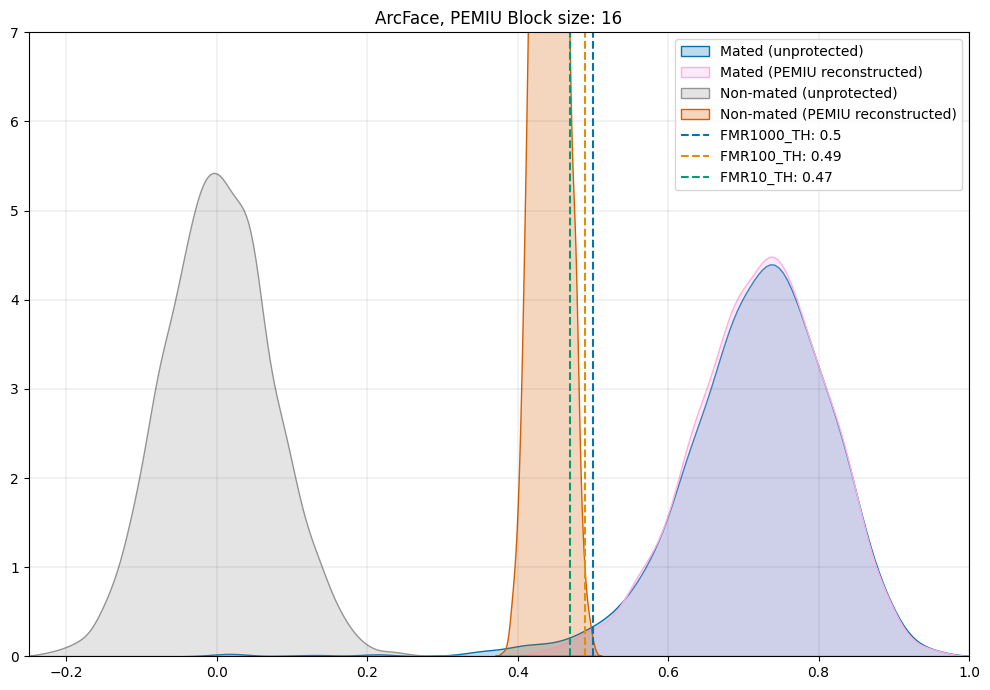

In [14]:
# Load df
df_pyeer = pd.read_csv(f"../evaluation/pyeer_lfwview2_pemiu{block_size}_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer.drop(df_pyeer.index[2:], inplace=True)

labels_th = ['FMR1000_TH', 'FMR100_TH', 'FMR10_TH']
colors = ["b", "r", "g", "c"]

fig, ax = plt.subplots(1, 1,
                        figsize = (10, 7),
                        tight_layout = True)

# Comparison: Genuine and imnpostor
sns.kdeplot(df_genuine['cos_sim_a_b'], label="Mated (unprotected)", fill=True, color=sns.color_palette("colorblind")[0])
sns.kdeplot(df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed'], label="Mated (PEMIU reconstructed)", fill=True, color=sns.color_palette("colorblind")[6])

sns.kdeplot(df_impostor['cos_sim_a_b'], label="Non-mated (unprotected)", fill=True, color=sns.color_palette("colorblind")[7])
sns.kdeplot(df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed'], label="Non-mated (PEMIU reconstructed)", fill=True, color=sns.color_palette("colorblind")[3])
# Comparison: target a pemiu and target a pemiu reconstrcuted of genuine and impostor

# Thresholds
for index, column in enumerate(labels_th):
    ax.axvline(x = round(((df_pyeer[column][1])), 2), 
               color = sns.color_palette("colorblind")[index], 
               linestyle="--",
               label = f'{labels_th[index]}: {round(df_pyeer[column][1], 2)}')

ax.legend()
ax.set(xlabel="")
ax.set(ylabel="")
ax.set_title(f"{feature_extractor}, PEMIU Block size: {block_size}")
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
plt.xlim([-0.25, 1])
plt.ylim([0, 7])
    
# Show plot
# plt.savefig(f'{save_path_plot}{filename_plot}', bbox_inches='tight')
plt.show()

## Pyeer report

- tbd

In [9]:
stats_unprotected = get_eer_stats(
    df_genuine['cos_sim_a_b'],
    df_impostor['cos_sim_a_b'],
    ds_scores=False)
stats_genuine_pemiu_reconstructed = get_eer_stats(
    df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed'],
    df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed'],
    ds_scores=False)

In [10]:
save_path = f"../evaluation/pyeer_lfwview2_pemiu{block_size}_biometric_performance/"
generate_eer_report([stats_unprotected,
                     stats_genuine_pemiu_reconstructed],
                    ['Unprotected',
                     'Genuine PEMIU Reconstructed'],
                    save_path + "eer_report.csv")

In [11]:
df_pyeer = pd.read_csv(f"../evaluation/pyeer_lfwview2_pemiu{block_size}_biometric_performance/eer_report.csv", 
                       sep=",", skiprows=[0])
df_pyeer.drop(df_pyeer.index[2:], inplace=True)
df_pyeer.T

,0,1
Experiment ID,Unprotected,Genuine PEMIU Reconstructed
GMean,0.716181,0.721597
GSTD,0.102242,0.088112
IMean,0.002586,0.442856
ISTD,0.071711,0.01848
Sensitivity index (d'),8.080924,4.378576
AUC,0.99924,0.998104
J-Index,0.995667,0.988
J-Index_TH,0.289894,0.498184
MCC,0.995676,0.988056


In [12]:
labels = ["TMR Zero\t\t", "TMR 1000 (10^3)\t\t", "TMR  100 (10^2)\t\t", "TMR   10\t\t"]

for i, title in enumerate(['Bona Fide Comparison Unprotected', 
                           f'Bona Fide Comparison PEMIU Protected (block size {block_size})']):
    print(f"\n{title}")
    for index, row in enumerate(df_pyeer[['ZeroFMR', 'FMR1000', 'FMR100', 'FMR10']]):
        print(f"{labels[index]}: {round(((1 - (df_pyeer[row].values[i])) * 100), 2)} %")


Bona Fide Comparison Unprotected
TMR Zero		: 99.57 %
TMR 1000 (10^3)		: 99.6 %
TMR  100 (10^2)		: 99.73 %
TMR   10		: 99.83 %

Bona Fide Comparison PEMIU Protected (block size 16)
TMR Zero		: 98.73 %
TMR 1000 (10^3)		: 98.87 %
TMR  100 (10^2)		: 99.17 %
TMR   10		: 99.6 %


In [13]:
df_genuine.head()

,index,a_filename,a_img,a_embedding_unmodified,a_embedding_pemiu,a_embedding_reconstructed,b_filename,b_img,b_embedding_unmodified,b_embedding_pemiu,cos_sim_a_pemiu_a_pemiu_reconstructed,cos_sim_a_b
0,0,Abel_Pacheco_0001,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner/Abel_Pacheco_0001.npy,../data/features_cleaner_pemiu/Abel_Pacheco_00...,../data/features_cleaner_pemiu16_reconstructed...,Abel_Pacheco_0004,../data/lfw_align/Abel_Pacheco/Abel_Pacheco_00...,../data/features_cleaner/Abel_Pacheco_0004.npy,../data/features_cleaner_pemiu/Abel_Pacheco_00...,0.736250,0.735583
1,1,Akhmed_Zakayev_0001,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0001.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,../data/features_cleaner_pemiu16_reconstructed...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0003.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,0.868533,0.868533
2,2,Akhmed_Zakayev_0002,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0002.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,../data/features_cleaner_pemiu16_reconstructed...,Akhmed_Zakayev_0003,../data/lfw_align/Akhmed_Zakayev/Akhmed_Zakaye...,../data/features_cleaner/Akhmed_Zakayev_0003.npy,../data/features_cleaner_pemiu/Akhmed_Zakayev_...,0.805964,0.805964
3,3,Amber_Tamblyn_0001,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner/Amber_Tamblyn_0001.npy,../data/features_cleaner_pemiu/Amber_Tamblyn_0...,../data/features_cleaner_pemiu16_reconstructed...,Amber_Tamblyn_0002,../data/lfw_align/Amber_Tamblyn/Amber_Tamblyn_...,../data/features_cleaner/Amber_Tamblyn_0002.npy,../data/features_cleaner_pemiu/Amber_Tamblyn_0...,0.733785,0.733785
4,4,Anders_Fogh_Rasmussen_0001,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/features_cleaner/Anders_Fogh_Rasmussen...,../data/features_cleaner_pemiu/Anders_Fogh_Ras...,../data/features_cleaner_pemiu16_reconstructed...,Anders_Fogh_Rasmussen_0003,../data/lfw_align/Anders_Fogh_Rasmussen/Anders...,../data/features_cleaner/Anders_Fogh_Rasmussen...,../data/features_cleaner_pemiu/Anders_Fogh_Ras...,0.763325,0.763325
